In [1]:
# https://youtu.be/XyX5HNuv-xE
"""
Multiclass semantic segmentation using U-Net
"""

# from simple_multi_unet_model import multi_unet_model #Uses softmax

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#connect your google drive
from google.colab import drive
drive.mount('/content/drive')

IMAGE_PATH = '/content/drive/MyDrive/annotation_data/images_128_128/*'
MASK_PATH = '/content/drive/MyDrive/annotation_data/masks_128_128/*'

SIZE_X = 128
SIZE_Y = 128
n_classes=11 #Number of classes for segmentation

Mounted at /content/drive


## Model Setup

In [2]:
# https://youtu.be/XyX5HNuv-xE
# https://youtu.be/q-p8v1Bxvac
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
  #comment
  # Build the model
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
  s = inputs

  #Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  #NOTE: Compile the model in the main program to make it easy to test with various loss functions
  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  #model.summary()

  return model

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


##Loading in masks and images

In [5]:
#file types
file_extensions = ["png"] #["jpg", "JPG", "jpeg", "png"]

#Get training images and mask paths then sort
train_images_fp = []
train_masks_fp = []
for directory_path in glob.glob(IMAGE_PATH):
  print(directory_path)
  for ext in file_extensions:
    for img_path in glob.glob(os.path.join(directory_path, f"*.{ext}")):
      train_images_fp.append(img_path)

for directory_path in glob.glob(MASK_PATH):
  print(directory_path)
  for ext in file_extensions:
    for mask_path in glob.glob(os.path.join(directory_path, f"*.{ext}")):
      train_masks_fp.append(mask_path)

#sort image and mask fps to ensure we have the same order to index
train_images_fp.sort()
train_masks_fp.sort()

#get actual masks and images
train_images = []
train_masks = []

for img_path in train_images_fp:
  img = cv2.imread(img_path, 0)
  train_images.append(img)

for mask_path in train_masks_fp:
  mask = cv2.imread(mask_path, 0)
  train_masks.append(mask)

#Convert list to array for machine learning processing
train_images = np.array(train_images)
train_masks = np.array(train_masks)

/content/drive/MyDrive/annotation_data/images_128_128/incomplete
/content/drive/MyDrive/annotation_data/images_128_128/body_attached
/content/drive/MyDrive/annotation_data/images_128_128/dorsal
/content/drive/MyDrive/annotation_data/images_128_128/damaged
/content/drive/MyDrive/annotation_data/masks_128_128/damaged
/content/drive/MyDrive/annotation_data/masks_128_128/incomplete
/content/drive/MyDrive/annotation_data/masks_128_128/dorsal
/content/drive/MyDrive/annotation_data/masks_128_128/body_attached


In [6]:
print(train_masks.shape)
print(train_images.shape)
np.unique(train_masks) #segmentation classes (should be 0-10)

(800, 128, 128)
(800, 128, 128)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

## Creating Train and Test Splits

In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
# Class weight balancing
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced', np.unique(train_masks_reshaped_encoded),train_masks_reshaped_encoded)
# print("Class weights are...:", class_weights)

## Train and Save U-Net Segmentation Model

In [13]:
# Train Model
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights.
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test_cat),
                    #class_weight=class_weights,
                    shuffle=False)



model_save_path = '/content/drive/MyDrive/annotation_data/unet_butterflies.hdf5'
model.save(model_save_path)

##Load in Trained UNet Model (optional)

In [8]:
# Load in trained model
model_save_path = '/content/drive/MyDrive/annotation_data/unet_butterflies.hdf5'
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights(model_save_path)

##Evaluate the Model - Accuracy

In [9]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

3/3 [==============================] - 10s 156ms/step - loss: 0.1108 - accuracy: 0.9721
Accuracy is =  97.21275568008423 %


In [10]:
# #plot the training and validation accuracy and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training Accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
# plt.title('Training and validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

## Evaluate the Model (IOU)

3/3 [==============================] - 0s 7ms/step
Mean IoU = 0.8250925


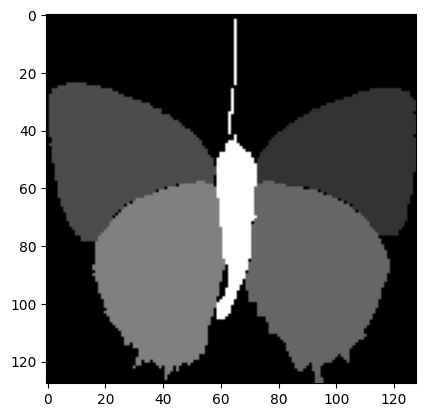

In [11]:
#Evaluate the model: Intersection Over Union (IOU)
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 11
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

In [ ]:
# #To calculate I0U for each class...
# values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
# print(values)
# class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
# class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
# class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
# class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

# print("IoU for class1 is: ", class1_IoU)
# print("IoU for class2 is: ", class2_IoU)
# print("IoU for class3 is: ", class3_IoU)
# print("IoU for class4 is: ", class4_IoU)

## Visualize Predicted Masks on a Few Images

1/1 [==============================] - 0s 21ms/step


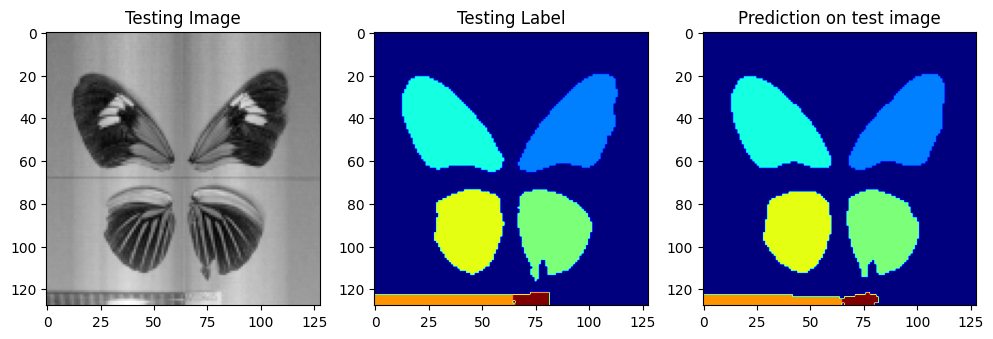

In [24]:
#Show prediction results on a few images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [25]:
test_img_number

68

In [26]:
np.unique(predicted_img) #predicted classes

array([0, 2, 3, 4, 5, 6, 8])

## Using Masks to Extract Wings
Save each segmented wing as its own JPG file to be used for landmarking by MLMorph

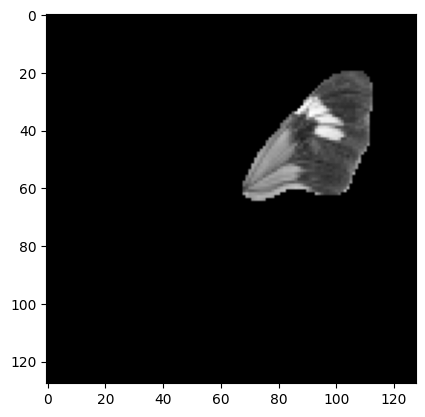

In [48]:
# crop image to right forewing (pixel value = 2)
# {0: 'background',
#  1: 'generic',
#  2: 'right_forewing',
#  3: 'left_forewing',
#  4: 'right_hindwing',
#  5: 'left_hindwing',
#  6: 'ruler',
#  7: 'white_balance',
#  8: 'label',
#  9: 'color_card',
#  10: 'body'}

img = test_img[:,:, 0]
mask = np.asarray(predicted_img==2, dtype=int) #0s and 1s
cropped = img * mask

plt.imshow(cropped, cmap='gray')
plt.show()


In [64]:
y_coords = []
x_coords = []
for y in range(0, mask.shape[0]):
  for x in range(0, mask.shape[1]):
    if mask[y,x]==1:
      x_coords.append(x)
      y_coords.append(y)

x_coords.sort()
y_coords.sort()

#get boundaries with some extra room
miny = y_coords[0] - 10
maxy = y_coords[-1] + 10
minx = x_coords[0] - 10
maxx= x_coords[-1] + 10


print("miny", miny)
print("minx", minx)

print("maxy", maxy)
print("maxx", maxx)

miny 10
minx 58
maxy 74
maxx 122


In [52]:
img.shape

(128, 128)

In [76]:
cropped_result = img[miny:maxy, minx:maxx]
cropped_result_resized = cv2.resize(cropped_result, (128,128), interpolation=cv2.INTER_CUBIC)

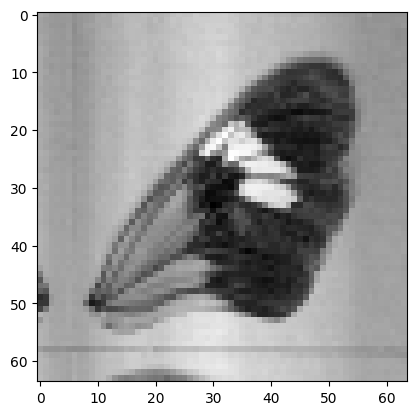

In [77]:
plt.imshow(cropped_result, cmap='gray');

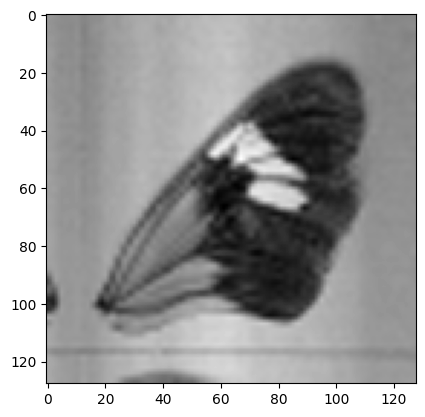

In [78]:
plt.imshow(cropped_result_resized, cmap='gray');